## In this notebook we perform PCA, MDS, and Isomap and look at the performance individually given different hyperparameters and in comparison to each other

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix
import support as sp

In [2]:
cols = ['animal_name','hair','feathers','eggs','milk','airborne','aquatic','predator','toothed','backbone','breathes','venomous','fins','legs','tail','domestic','catsize','type']
df = pd.read_table('zoo.data',sep=',',names=cols)

#outsource 'animal_name' and 'type'
y = df['animal_name']
typ = df['type']
del df['animal_name']
del df['type']
X = df.to_numpy()

In [3]:
#one hot encode 'legs' so I only have binary data. 
df_ohc_legs = pd.get_dummies(df['legs'], prefix='legs')
df_temp = df.copy()
del df_temp['legs']
df_ohc = pd.concat([df_temp, df_ohc_legs], axis=1, join='inner')
X_ohc = df_ohc.to_numpy()

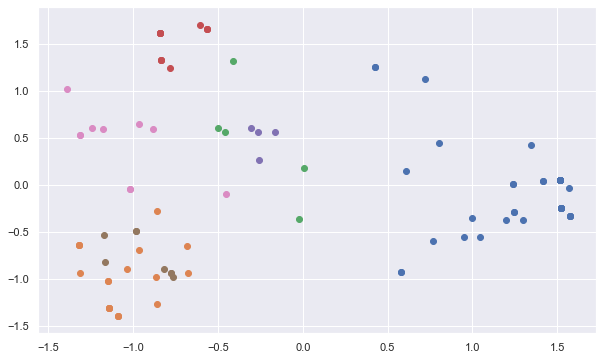

In [4]:
#pca with one hot encoded legs and plot components 
df_pca= sp.do_pca(df_ohc, 2, typ)
for i in np.unique(typ):
    temp = df_pca[df_pca['type']==i]
    plt.scatter(temp['comp0'],temp['comp1'])

## plot the number of components against the explained Varinace

In [5]:
#compute the eigenvalues of the covariancematrix
matrix = df_ohc.to_numpy()
cov = matrix.T @ matrix
eigenValues, eigenVectors = np.linalg.eig(cov)

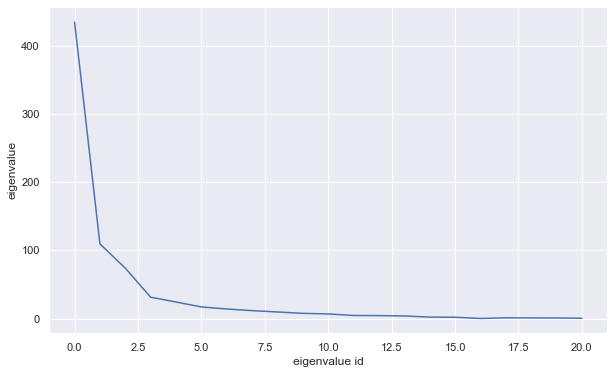

In [6]:
#plot eigenvalues
plt.plot(eigenValues)
plt.xlabel('eigenvalue id')
plt.ylabel('eigenvalue')
plt.show()

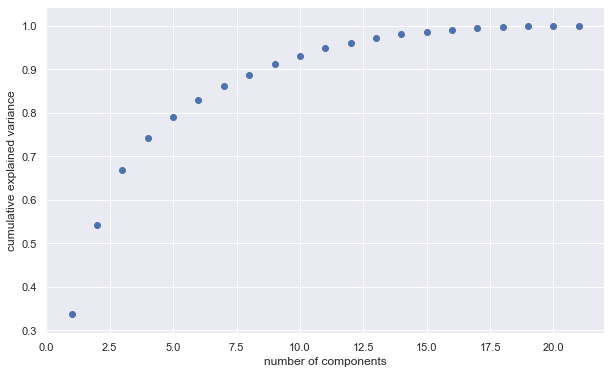

In [7]:
#plot components against explained variance
pca = PCA()
pca.fit(df_ohc)
plt.scatter([i for i in range(1,22)],np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [8]:
np.cumsum(pca.explained_variance_ratio_)

array([0.33692871, 0.54146981, 0.66984816, 0.74183934, 0.79002974,
       0.82910056, 0.86159237, 0.88833617, 0.91145678, 0.9304584 ,
       0.94924455, 0.96165012, 0.97302107, 0.98114993, 0.98667568,
       0.99171241, 0.99477348, 0.99737396, 0.99904364, 1.        ,
       1.        ])

### As we can see in the plot and in the Matrix above, we will only explain 54% of the Variance with two components. To keep over 85% of the explained variance, we have to keep 7 Components.

# b) MDS

In [9]:
#compute distance matrix
D = distance_matrix(df_ohc, df_ohc)

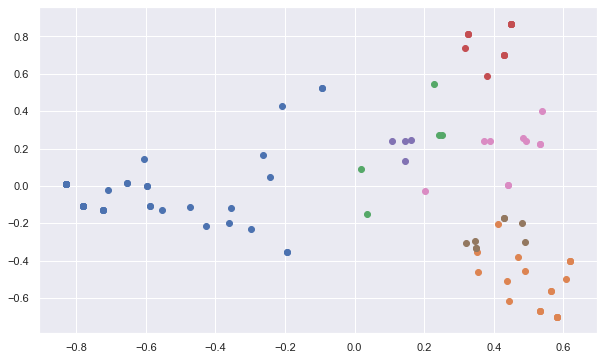

In [10]:
#perform mds and plot results
df_mds = sp.mds(D,2,typ)
X_mds = df_mds[['comp0','comp1']].to_numpy()
for i in np.unique(df_mds['type']):
    temp = df_mds[df_mds['type']==i]
    plt.scatter(temp['comp0'],temp['comp1'])

#### feature selection for MDS via chi square test

In [11]:
from sklearn.feature_selection import chi2
names = ['hair','feathers','eggs','milk','airborne','aquatic','predator','toothed','backbone','breathes','venomous','fins','legs','tail','domestic','catsize']

In [12]:
#we can use feature selection on the oringinal matrix
chi_values, p_values = chi_scores = chi2(df,typ)
print(p_values)

[8.04934922e-09 2.22019834e-15 1.45836034e-06 4.50101665e-11
 6.75332412e-09 4.16283012e-05 4.89858353e-01 1.71405187e-06
 6.23219511e-03 8.11568985e-03 7.34308886e-03 1.36077029e-11
 2.04703147e-15 9.73283940e-03 6.50641226e-01 1.85291522e-03]


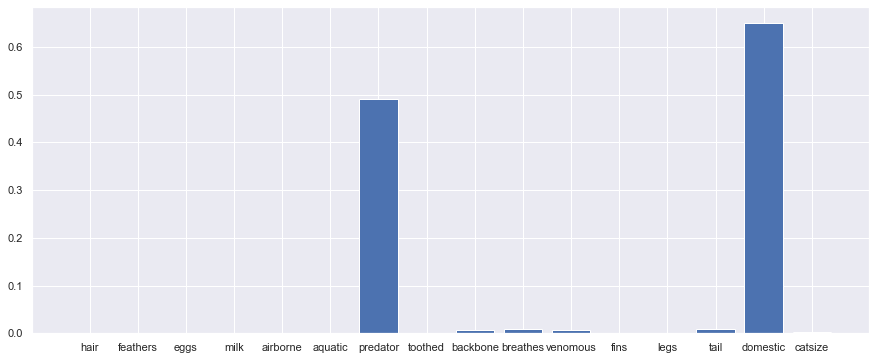

In [13]:
#plot the p values of the different features
plt.rcParams["figure.figsize"] = (15,6)
plt.bar(names,p_values)
plt.show()

predator and domenstic have both a p-value above 0.05, therefore they can be considered independent of type and that is why we are not taking them into consideration for the next MDS

In [14]:
#delete the columns predeator and domestic 
names = ['hair','feathers','eggs','milk','airborne','aquatic','toothed','backbone','breathes','venomous','fins','tail','catsize']
df_sel = df[names]
df_ohc_sel = pd.concat([df_sel, df_ohc_legs], axis=1, join='inner')

D_sel = distance_matrix(df_ohc_sel, df_ohc_sel)

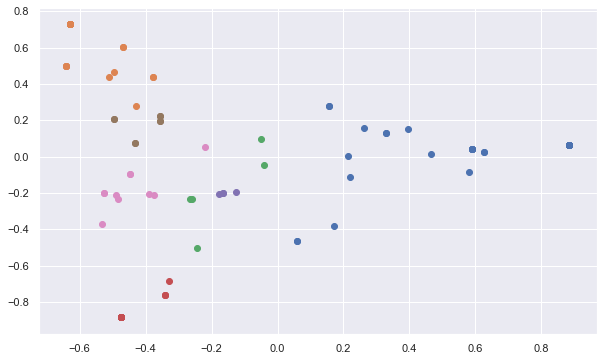

In [15]:
#perform mds on the new data and plot results
plt.rcParams["figure.figsize"] = (10,6)
df_mds_sel = sp.mds(D_sel,2,typ)
for i in np.unique(df_mds_sel['type']):
    temp = df_mds_sel[df_mds_sel['type']==i]
    plt.scatter(temp['comp0'],temp['comp1'])

#### As we can see the result does almost not change compared to performing MDS on the entire dataset. This shows that the deleted columns indeed where irrelevant

# c) Isomap

#### before plotting anything we compare the reconstruction error and local similarity between Isomap performed with different neighbours k

In [16]:
#compare local similarity
erg = []
for i in range(3,40):
    df_ims = sp.Isomap(D,i,2,typ)
    f = df_ims[['comp0','comp1']].to_numpy()
    D_fit = distance_matrix(f,f)
    error = sp.compare_local(D,D_fit,10)
    erg.append((error,i))

erg = sorted(erg, key =lambda x: x[0],reverse=True)
print(erg[0])

(0.42079207920792094, 7)


In [17]:
#compute the reconstruction error for different values of k (neighbours)
#more global
erg = []
for i in range(3,40):
    df_ims = sp.Isomap(D,i,2,typ)
    f = df_ims[['comp0','comp1']].to_numpy()
    D_fit = distance_matrix(f,f)
    error = sp.rec_error(D,D_fit,Isomap=1)
    erg.append((error,i))

erg = sorted(erg, key =lambda x: x[0])
print(erg[0])

(0.0002053277454887713, 7)


### the result above does give reason to choose 7 neighbours for the isomap, since it gives the lowest reconstruction error and the higest local similarity

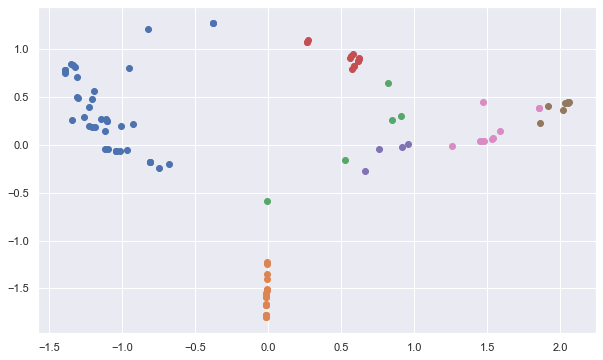

In [18]:
df_ims = sp.Isomap(D,7,2,typ)
X_ims = df_ims[['comp0','comp1']].to_numpy()
for i in np.unique(df_ims['type']):
    temp = df_ims[df_ims['type']==i]
    plt.scatter(temp['comp0'],temp['comp1'])
plt.show()

# compare the different methods  
#### we compare all methods in 2 dimensions

## compare performance by seperability

In [19]:
#check performance for d = 2
d=2
C = 1000
data = {'Isomap': sp.Isomap(D,7,d,typ), 'MDS':sp.mds(D_sel,d,typ), 'PCA': sp.do_pca(df_ohc, d, typ)}
for key in data:
    score = sp.seperability(C, data[key])
    print('score {} = {}'.format(key,score))

score Isomap = 1.0
score MDS = 0.9900990099009901
score PCA = 0.9405940594059405


In [20]:
#check performance for d = 5
d=5
C = 0.5
data = {'Isomap': sp.Isomap(D,7,d,typ), 'MDS':sp.mds(D_sel,d,typ), 'PCA': sp.do_pca(df_ohc, d, typ)}
for key in data:
    score = sp.seperability(C, data[key])
    print('score {} = {}'.format(key,score))

score Isomap = 0.9900990099009901
score MDS = 0.8910891089108911
score PCA = 0.9702970297029703


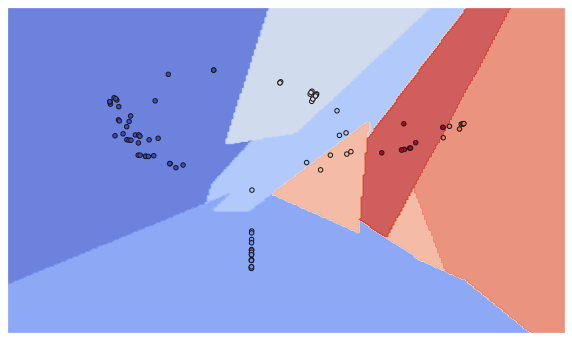

In [21]:
#plott of the decision boundarys on the isomap data 
from sklearn import svm
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

clf = svm.SVC(kernel='linear',C=1000)
clf.fit(df_ims[['comp0','comp1']], df_ims['type'])
y_pred = clf.predict(df_ims[['comp0','comp1']])

fig, ax = plt.subplots()
# Set-up grid for plotting.
X0, X1 = df_ims['comp0'], df_ims['comp1']
xx, yy = make_meshgrid(X0, X1)
y = df_ims['type']
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xticks(())
ax.set_yticks(())
plt.show()